In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arketing-campaign/marketing_campaign.csv
/kaggle/input/arketing-campaign/marketing_campaign.xlsx


The project aims to cluster and extract insights from different members through demographic, buying and responding to marketing offers behaviours. <br>
The last part tests different prediction models to forecast the next campaign acceptances.

In [2]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from scipy.stats import zscore
import datetime as dt
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='ticks', palette='Set2')
import pandas as pd
import numpy as np
from kmodes.kprototypes import KPrototypes
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, silhouette_score, confusion_matrix
from imblearn.over_sampling import SMOTE
# for modeling
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

# Preprocessing

Define a function to classify features into numerical and categorical features. It is convenient for datasets with many features, and the function could be reused for other projects.

In [3]:
def classify_col(df,y_name):
    '''
    Get names of categorical and numerical features
    Return 2 name lists <list>
    '''
    num_col = []
    cat_col = []
    numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64','datetime64']
    
    for col in df.columns.values.tolist():
        if df[col].dtype in numerics and col != y_name:
            num_col.append(col)
        if df[col].dtype in ['object','category'] and col != y_name:
            cat_col.append(col)
    return cat_col, num_col

In [4]:
df_raw = pd.read_csv('/kaggle/input/arketing-campaign/marketing_campaign.csv',sep =';')
df_raw.info()
print(' ')
print('Number of members: % s' % len(df_raw.ID.unique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

The dataset contains 2240 rows with 28 features. Each row represents a member.<br>

Content <br>
*     AcceptedCmp1 - 1 if customer accepted the offer in the 1st campaign, 0 otherwise <br>
*     AcceptedCmp2 - 1 if customer accepted the offer in the 2nd campaign, 0 otherwise <br>
*     AcceptedCmp3 - 1 if customer accepted the offer in the 3rd campaign, 0 otherwise <br>
*     AcceptedCmp4 - 1 if customer accepted the offer in the 4th campaign, 0 otherwise <br>
*     AcceptedCmp5 - 1 if customer accepted the offer in the 5th campaign, 0 otherwise <br>
*     Response (target) - 1 if customer accepted the offer in the last campaign, 0 otherwise <br>
*     Complain - 1 if customer complained in the last 2 years <br>
*     DtCustomer - date of customer’s enrolment with the company <br>
*     Education - customer’s level of education <br>
*     Marital - customer’s marital status <br>
*     Kidhome - number of small children in customer’s household <br>
*     Teenhome - number of teenagers in customer’s household <br>
*     Income - customer’s yearly household income <br>
*     MntFishProducts - amount spent on fish products in the last 2 years <br>
*     MntMeatProducts - amount spent on meat products in the last 2 years <br>
*     MntFruits - amount spent on fruits products in the last 2 years <br>
*     MntSweetProducts - amount spent on sweet products in the last 2 years <br>
*     MntWines - amount spent on wine products in the last 2 years <br>
*     MntGoldProds - amount spent on gold products in the last 2 years <br>
*     NumDealsPurchases - number of purchases made with discount <br>
*     NumCatalogPurchases - number of purchases made using catalogue <br>
*     NumStorePurchases - number of purchases made directly in stores <br>
*     NumWebPurchases - number of purchases made through company’s web site <br>
*     NumWebVisitsMonth - number of visits to company’s web site in the last month <br>
*     Recency - number of days since the last purchase <br>

Some binary features are categories needed to change the type <br>
From `Dt_Customer`, compute the `Day` feature -  days joining the membership program. <br>
From `Year_Birth`, compute the `Age` feature (assume 2014 is the current year)


In [5]:
#Check type
df_raw.select_dtypes('object').nunique()
df_raw[['AcceptedCmp3',
    'AcceptedCmp1',
    'AcceptedCmp2',
    'AcceptedCmp4',
    'AcceptedCmp5',
    'Complain',
    'Response']] = df_raw[['AcceptedCmp3',
                       'AcceptedCmp1',
                       'AcceptedCmp2',
                       'AcceptedCmp4',
                       'AcceptedCmp5',
                       'Complain',
                       'Response']].astype('object')

# Convert Dt_Customer into Day and Year_Birth into Age
df_raw['Dt_Customer'] = pd.to_datetime(df_raw['Dt_Customer'])
df_raw['Day'] = (df_raw['Dt_Customer'].max()- df_raw['Dt_Customer'])
df_raw['Day'] = df_raw['Day'].dt.days
df_raw = df_raw[df_raw['Day']!=0]
df_raw['Age'] = df_raw['Dt_Customer'].max().year-df_raw['Year_Birth']

df_raw.info()
df_raw.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2238 entries, 0 to 2239
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   2238 non-null   int64         
 1   Year_Birth           2238 non-null   int64         
 2   Education            2238 non-null   object        
 3   Marital_Status       2238 non-null   object        
 4   Income               2214 non-null   float64       
 5   Kidhome              2238 non-null   int64         
 6   Teenhome             2238 non-null   int64         
 7   Dt_Customer          2238 non-null   datetime64[ns]
 8   Recency              2238 non-null   int64         
 9   MntWines             2238 non-null   int64         
 10  MntFruits            2238 non-null   int64         
 11  MntMeatProducts      2238 non-null   int64         
 12  MntFishProducts      2238 non-null   int64         
 13  MntSweetProducts     2238 non-nul

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Day,Age
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,0,0,0,0,0,3,11,1,663,57
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,0,0,0,0,0,3,11,0,113,60
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,0,0,0,0,0,3,11,0,312,49
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,0,0,0,0,0,3,11,0,139,30
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,0,0,0,0,0,3,11,0,161,33


The next step is to check and clean data for the final df. <br>
* Remove members just joining the membership (`Day` == 0) <br>
* Remove NA values <br>
* Check and remove duplicate values <br>
* Drop unclear, unique and the target columns
* Check and remove outliers using zscore <br>

In [6]:
# Remove members who just join the membership program
df_raw = df_raw[df_raw['Day']>0]

# Check NA
print('Removed %s NA values' % df_raw.isna().sum().sum())
print(' ')
df_raw = df_raw.dropna()

# Check duplicates
dupli_sum = df_raw.duplicated().sum()
if(dupli_sum > 0):
    df_raw = df_raw.loc[False == df_raw.duplicated(), :]
    print("Removed %s duplicates" % dupli_sum)
    print(' ')
else:
    print("No duplicates found")
    print(' ')

drop_col = ['Z_CostContact','ID','Z_Revenue','Dt_Customer','Year_Birth']
df_raw=df_raw.drop(drop_col,axis=1).reset_index(drop = True)
print('Dropped columns %s ' % drop_col)
print(' ')

#Get categorical and numerical columns name
cat_col,num_col = classify_col(df_raw,'Response')
cat_loc = [df_raw.columns.get_loc(col) for col in cat_col]

# Remove outliers for categorical features
s = len(df_raw)
for i in cat_col:
    df_raw[i].value_counts()
df_raw = df_raw[df_raw['Marital_Status'].isin(['Alone','Absurd','YOLO']) == False].reset_index(drop=True)
# Remove outliers for numerical features
df_raw[num_col].describe()
z = df_raw[['Income','Age']].apply(zscore)
idx = list(np.where(z.apply(abs) >3)[0])
df_raw = df_raw.drop(idx,axis=0).reset_index(drop=True)
df_raw[num_col].describe()
e = len(df_raw)
print('Removed %s outliers' % (s-e))
print(' ')

df_raw.head()

Removed 24 NA values
 
No duplicates found
 
Dropped columns ['Z_CostContact', 'ID', 'Z_Revenue', 'Dt_Customer', 'Year_Birth'] 
 
Removed 18 outliers
 


,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Day,Age
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,7,0,0,0,0,0,0,1,663,57
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,5,0,0,0,0,0,0,0,113,60
2,Graduation,Together,71613.0,0,0,26,426,49,127,111,...,4,0,0,0,0,0,0,0,312,49
3,Graduation,Together,26646.0,1,0,26,11,4,20,10,...,6,0,0,0,0,0,0,0,139,30
4,PhD,Married,58293.0,1,0,94,173,43,118,46,...,5,0,0,0,0,0,0,0,161,33


The dataset is label encoded and min-max scaled before fitting into the clustering model to get better results.


In [7]:
#Encoding and saving different dataframe for different purposes
df = df_raw.copy()
df_y = df['Response']
df = df.drop('Response', axis= 1)
df[cat_col] = df[cat_col].apply(LabelEncoder().fit_transform)
scaler = MinMaxScaler()  # MinMaxScaler()
dfMatrix = scaler.fit_transform(df)
df_scaled = pd.DataFrame(dfMatrix, columns=df.columns)

df_scaled.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Day,Age
0,0.5,0.50,0.503625,0.0,0.0,0.585859,0.425318,0.442211,0.316522,0.664093,...,0.307692,0.35,0.0,0.0,0.0,0.0,0.0,0.0,0.948424,0.696429
1,0.5,0.50,0.398325,0.5,0.5,0.383838,0.007368,0.005025,0.003478,0.007722,...,0.153846,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.160458,0.750000
2,0.5,0.75,0.623933,0.0,0.0,0.262626,0.285332,0.246231,0.073623,0.428571,...,0.769231,0.20,0.0,0.0,0.0,0.0,0.0,0.0,0.445559,0.553571
3,0.5,0.75,0.222456,0.5,0.0,0.262626,0.007368,0.020101,0.011594,0.038610,...,0.307692,0.30,0.0,0.0,0.0,0.0,0.0,0.0,0.197708,0.214286
4,1.0,0.25,0.505009,0.5,0.0,0.949495,0.115874,0.216080,0.068406,0.177606,...,0.461538,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.229226,0.267857


# Clustering
The dataset contains both category and numeric features; hence `KPrototypes` is suitable for clustering. <br>
Choose the optimal k clusters by silhouette score.

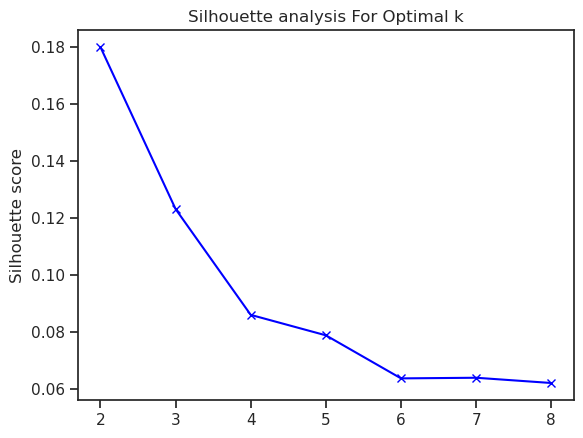

In [8]:
# Choose K
range_n_clusters = [2, 3, 4, 5, 6,7,8]
silhouette_avg = []
for num_clusters in range_n_clusters:
    # initialise kproto
    kproto = KPrototypes(n_clusters=num_clusters,random_state=0)
    kproto.fit(dfMatrix,categorical = cat_loc)
    cluster_labels = kproto.labels_
    # silhouette score
    silhouette_avg.append(silhouette_score(dfMatrix, cluster_labels))
plt.plot(range_n_clusters,silhouette_avg,'bx-')   
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

The optimal k is 2 which has the highest score. <br>

Run the model again with k =2 to get `ClusterLabels` column.

In [9]:
# The optimal k
k=2

# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = k, random_state = 0)
kprototype.fit_predict(dfMatrix, categorical = cat_loc)

# Add the cluster to the dataframes
df_scaled['ClusterLabels'] = kprototype.labels_
df['ClusterLabels'] = kprototype.labels_
df_raw['ClusterLabels'] = kprototype.labels_

df_scaled['ClusterLabels'].value_counts()

1    1202
0     994
Name: ClusterLabels, dtype: int64

Cluster 0 has 994 members and cluster 1 has 1202 members.

# Exploring insights
Features are divided into demographics and behaviours features to analyse insights.
### 1 - Who are they?


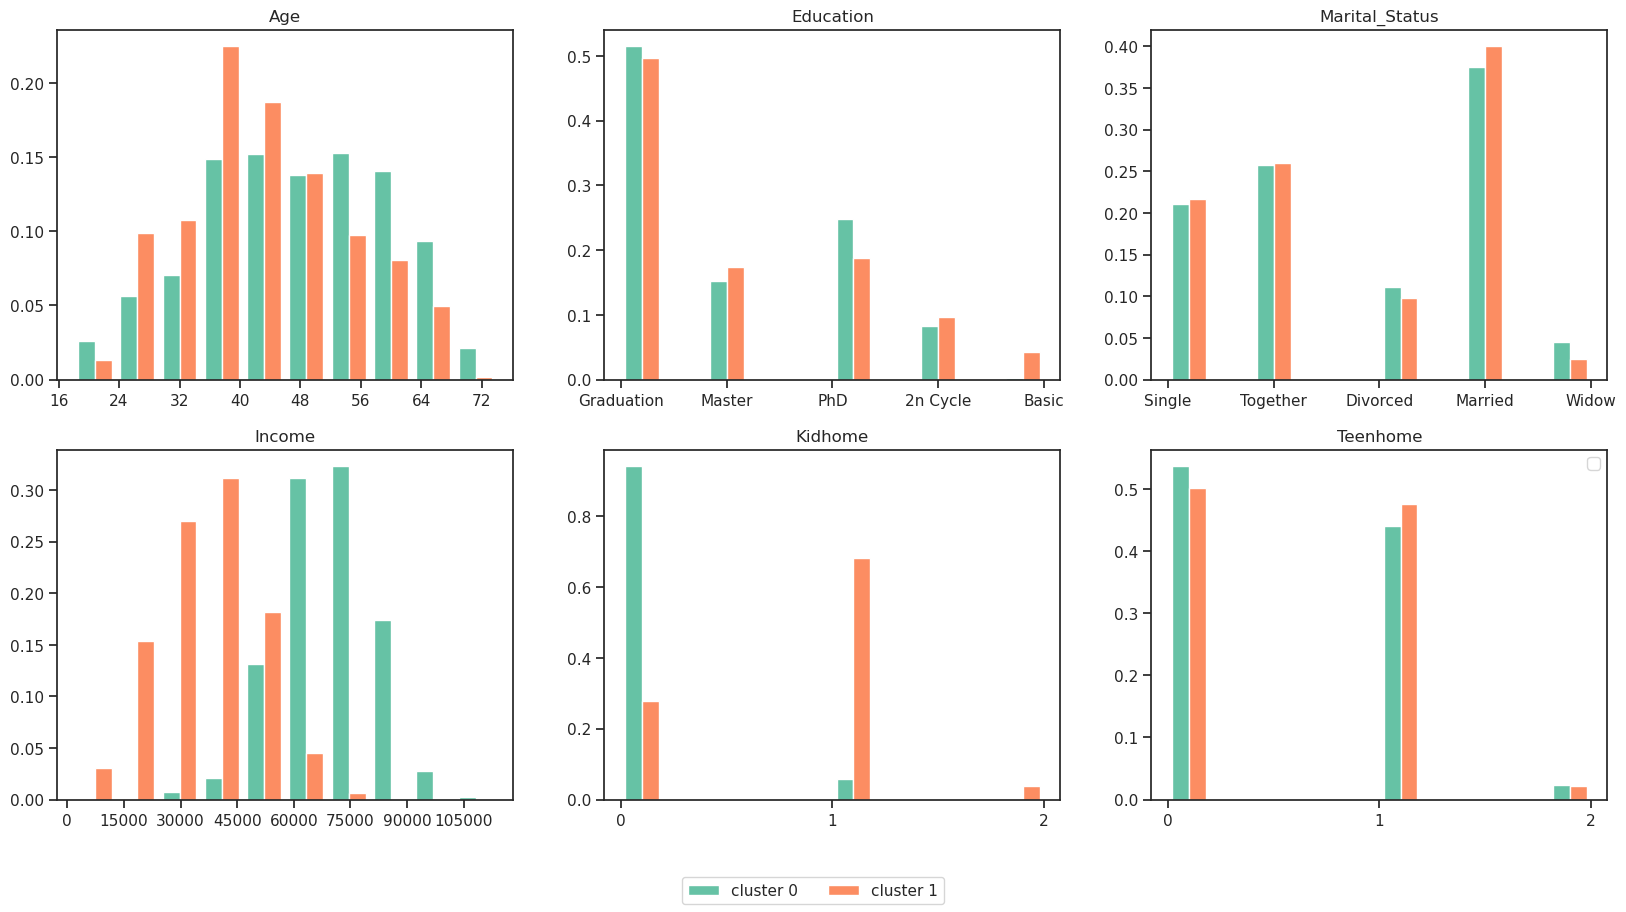

Mean age each clusters: 
 ClusterLabels
0    47.552314
1    43.066556
Name: Age, dtype: float64
 
Mean income each clusters: 
 ClusterLabels
0    69621.802817
1    36726.458403
Name: Income, dtype: float64
 


In [10]:
# Divide features and filter data for each cluster
demo_col = ['Age', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome']
beha_col = ['MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain',  'Recency', 'Day']

df1 = df_raw[df_raw['ClusterLabels']==1]
df0 = df_raw[df_raw['ClusterLabels']==0]

# Histogram demographic features
fig,[(ax1,ax2,ax3),(ax4,ax5,ax6)] = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))
w0 =[1/ len(df0)]*len(df0)
w1 = [1/ len(df1)]*len(df1)
for i, ax in zip(demo_col,[ax1,ax2,ax3,ax4,ax5,ax6]):
    ax.hist([df0[i],df1[i]], 
            weights=[w0,w1],
            align='mid')
    ax.set_title(label = i)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
fig.legend(labels=['cluster 0', 'cluster 1'], 
           loc='lower center',
           ncol=len(['cluster 0', 'cluster 1']), 
           bbox_transform=fig.transFigure)
plt.legend()
plt.show()


a = df_raw.groupby('ClusterLabels')['Age'].mean()
print('Mean age each clusters: \n %s' % a)
print(' ')
i = df_raw.groupby('ClusterLabels')['Income'].mean()
print('Mean income each clusters: \n %s' % i)
print(' ')

**Insight**
* In general: Age 35-60, Graduation + PhD + Master, Income 30k-70k, Married + Together + Single, 0-1 kid and 0-1 teen at home <br>
* Cluster 0: Age 35-64/ Older audience + few kid and teen + high income (with mean income ~ 69k) + more PhD + more divorced & widow <br>
* Cluster 1: Age 25-50/ Younger audience + more kid and teen + low income (with mean income ~ 37k) + more Married <br>

### 2 - How do they behave when shopping?
Behaviour features are splited into categorical, amount, and purchasing channel features.

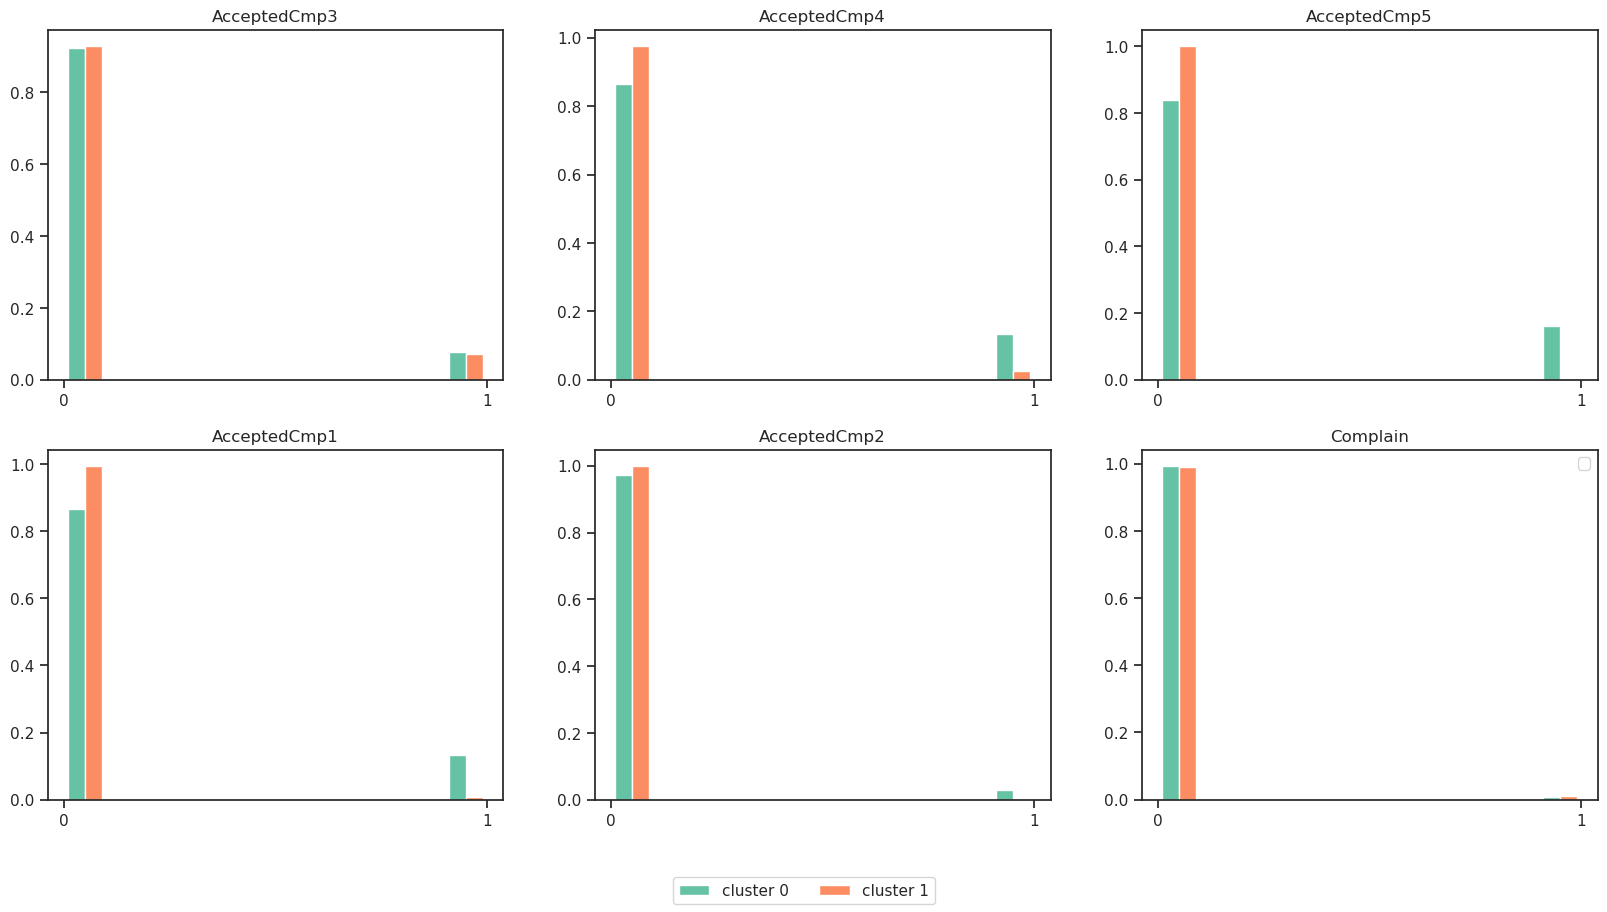

In [11]:
# Split features
beha_cat = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 
            'AcceptedCmp1', 'AcceptedCmp2', 'Complain']
mnt_col = [col for col in df if col.startswith('Mnt')]
pur_col = [col for col in df if col.startswith('Num') and col.endswith('Purchases')]

# Histogram campaign acceptances and complaints.
fig,[(ax1,ax2,ax3),(ax4,ax5,ax6)] = plt.subplots(ncols=3, 
                                                 nrows=2, 
                                                 figsize=(20, 10))
w0 =[1/ len(df0)]*len(df0)
w1 = [1/ len(df1)]*len(df1)
for i, ax in zip(beha_cat,[ax1,ax2,ax3,ax4,ax5,ax6]):
    ax.hist([df0[i],df1[i]], 
            weights=[w0,w1])
    ax.set_title(label = i)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
fig.legend(labels=['cluster 0', 'cluster 1'], 
           loc='lower center',
           ncol=len(['cluster 0', 'cluster 1']), 
           bbox_transform=fig.transFigure)
plt.legend()
plt.show()

**Insight**
* Some campaigns (1, 4, 5) worked well with cluster 0 but cluster 1 did not join much.
* Cluster 0 engages more in campaigns than cluster 1. 
* Campaign 3  attracted various audiences. This campaign indicated that cluster 1 is interested in marketing campaigns, but maybe offers in campaigns did not attract them, so they did not accept campaigns much. It also means the differences in the interest of 2 clusters; hence, it is necessary to launch 2 types of offer in one campaign or separate campaigns for each group to maximise the offer acceptance of both groups <br>
* Not many customers make complaints which is good. 

In [12]:
print('Mean days joining the membership program:')
df_raw.groupby('ClusterLabels')['Day'].mean()

Mean days joining the membership program:


ClusterLabels
0    375.445674
1    336.294509
Name: Day, dtype: float64

**Insight**: Cluster 0 has joined with the company longer than cluster 1.

In [13]:
mnt_pur0 = df_raw[df_raw['ClusterLabels']==0][mnt_col].values.sum()/df_raw[df_raw['ClusterLabels']==0][pur_col].values.sum()
mnt_pur1 = df_raw[df_raw['ClusterLabels']==1][mnt_col].values.sum()/df_raw[df_raw['ClusterLabels']==1][pur_col].values.sum()
print('Average amount per purchase of cluster 0: % s ' % mnt_pur0)
print('Average amount per purchase of cluster 1: % s ' % mnt_pur1)

Average amount per purchase of cluster 0: 54.54121439067166 
Average amount per purchase of cluster 1: 15.775198481187434 


**Insight**: Cluster 0 often spends more on one purchase than cluster 1. Cluster 0 spends more than 3 times in one purchase compared to cluster 0.

In [14]:
df_raw['TotalAmounts'] = df_raw.loc[:,mnt_col].sum(axis=1)
df_raw['TotalWebVisits'] = round(df_raw['NumWebVisitsMonth']*((df_raw['Day']/7)/4))
df_raw['TotalPurchases'] = df_raw.loc[:,pur_col].sum(axis=1)

df_raw['PurPerMonth'] = df_raw['TotalPurchases']/((df_raw['Day']/7)/4)
print('Number of purchases per month : ')
df_raw.groupby('ClusterLabels')['PurPerMonth'].mean()

Number of purchases per month : 


ClusterLabels
0    6.032075
1    2.175196
Name: PurPerMonth, dtype: float64

**Insight**: While cluster 0 makes around 6 purchases per month, cluster 1 makes around 2 purchases per month.

In [15]:
v = df_raw.groupby('ClusterLabels')['NumWebVisitsMonth'].mean()
cvr = df_raw.groupby('ClusterLabels')['NumWebPurchases'].sum()/df_raw.groupby('ClusterLabels')['TotalWebVisits'].sum()
print('Mean website visits per month: \n %s' % v )
print(' ')
print('Average conversion rates in website: \n %s' % cvr)

Mean website visits per month: 
 ClusterLabels
0    3.896378
1    6.528286
Name: NumWebVisitsMonth, dtype: float64
 
Average conversion rates in website: 
 ClusterLabels
0    0.096335
1    0.033386
dtype: float64


**Insight**
* Cluster 0 visits the website 4 times a month, while cluster 1 visits more often. <br>
* However, the conversion rate of website purchases of cluster 0 is higher than cluster 1.

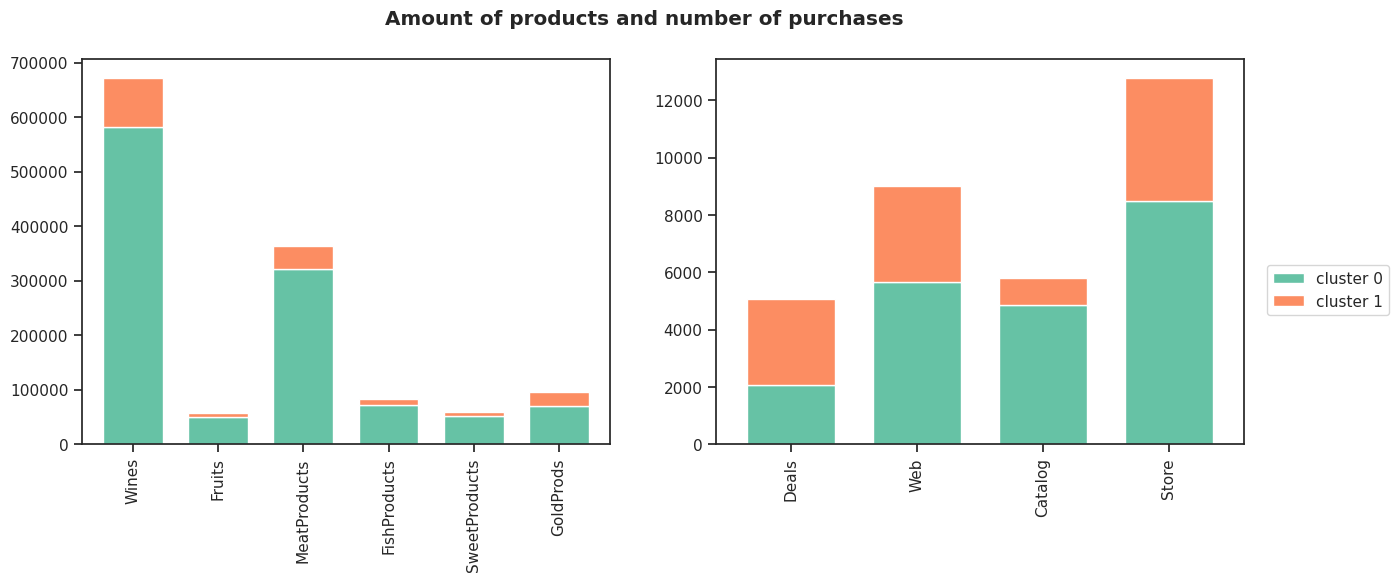

In [16]:
# Overall amount and purchases chart
fig,(ax1,ax2) = plt.subplots(ncols = 2)
s0 = df_raw.groupby('ClusterLabels')[mnt_col].sum().reset_index(drop = True)
s0.T.plot.bar(stacked=True,
            width=0.7,
            legend=False,
            ax= ax1,
            figsize=(15, 5))
s1 = df_raw.groupby('ClusterLabels')[pur_col].sum().reset_index(drop = True)
s1.T.plot.bar(stacked=True,
            width=0.7,
            legend=False,
            ax= ax2,
            figsize=(15, 5))
fig.legend(labels=['cluster 0', 'cluster 1'], 
           loc='center right',
           ncol=1, 
           bbox_transform=fig.transFigure)
ax1.set_xticklabels([i[3:] for i in mnt_col])
ax2.set_xticklabels([i[3:-9] for i in pur_col])
fig.suptitle('Amount of products and number of purchases',fontweight='bold')
plt.show()

**Insight**
* Wine is the most buying amount product. Following are meat products.
* Both customers made the most purchases at stores and on the website.
* Although the amounts differ, demand patterns across products are similar between the 2 clusters. 
* Cluster 0 accounts for a major percentage in both amount and number of purchases, except the number of deal purchases.


### 3 - What, where and how do they buy products?


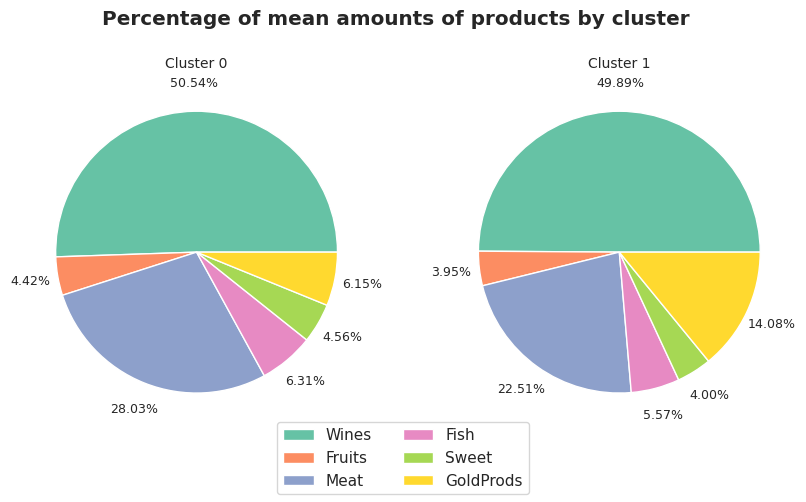

In [17]:
# Pie chart for amounts
s= df_raw.groupby('ClusterLabels')[mnt_col].mean()
fig, axes = plt.subplots(ncols=2,figsize = (10,5))
for ax, i in zip(axes,s.index):
    ax.pie(
            s.iloc[i,:], 
            pctdistance=1.2, 
            labeldistance=1.3 , 
            autopct='%1.2f%%',
            textprops={'fontsize': 9},
            )   
    ax.set_title('Cluster %s' % i, fontsize =10)
fig.suptitle('Percentage of mean amounts of products by cluster',fontweight='bold')
fig.legend(labels=[i[3:].replace('Products','') for i in mnt_col],
           loc='lower center',
           ncol=2,
           bbox_transform=fig.transFigure)
plt.show()

**Insight**
* Percentage across products in the 2 clusters are quite similar in wines, fruits, fish and sweet products
* Cluster 1 spends more shopping budget percentages on gold products than cluster 0.
* Cluster 0 spends more shopping budget percentages on meat products than cluster 1.

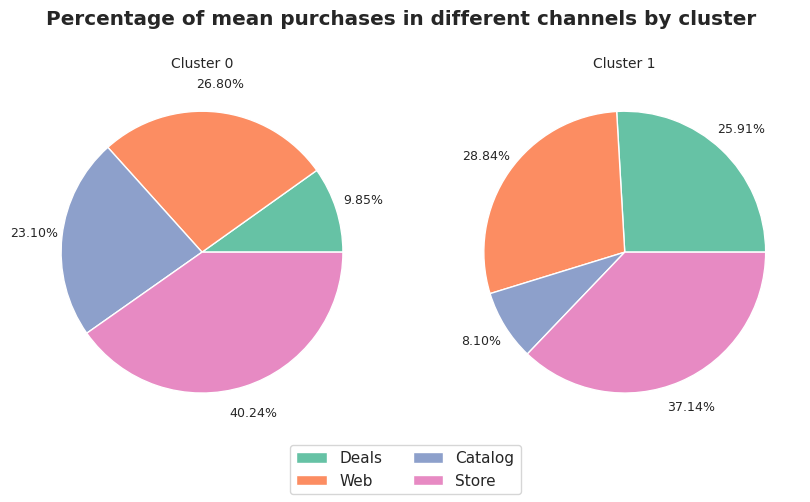

In [18]:
# Pie chart for purchase features
s= df_raw.groupby('ClusterLabels')[pur_col].mean()
fig, axes = plt.subplots(ncols=2,figsize = (10,5))
for ax, i in zip(axes,s.index):
    ax.pie(
            s.iloc[i,:], 
            pctdistance=1.2, 
            labeldistance=1.3 , 
            autopct='%1.2f%%',
            textprops={'fontsize': 9},
            )   
    ax.set_title('Cluster %s' % i, fontsize =10)
fig.suptitle('Percentage of mean purchases in different channels by cluster',fontweight='bold')
fig.legend(labels=[i[3:-9] for i in pur_col],
           loc='lower center',
           ncol=2,
           bbox_transform=fig.transFigure)
plt.show()


**Insight**
* Both clusters have a high number of purchases in-store and website
* Cluster 1 prefers deal purchases
* Cluster 0 prefers catalogue purchases

The heatmap is suitable for presenting a correlation between features. The darker colour denoted a higher positive correlation, while the brighter one denoted a low positive or high negative correlation.

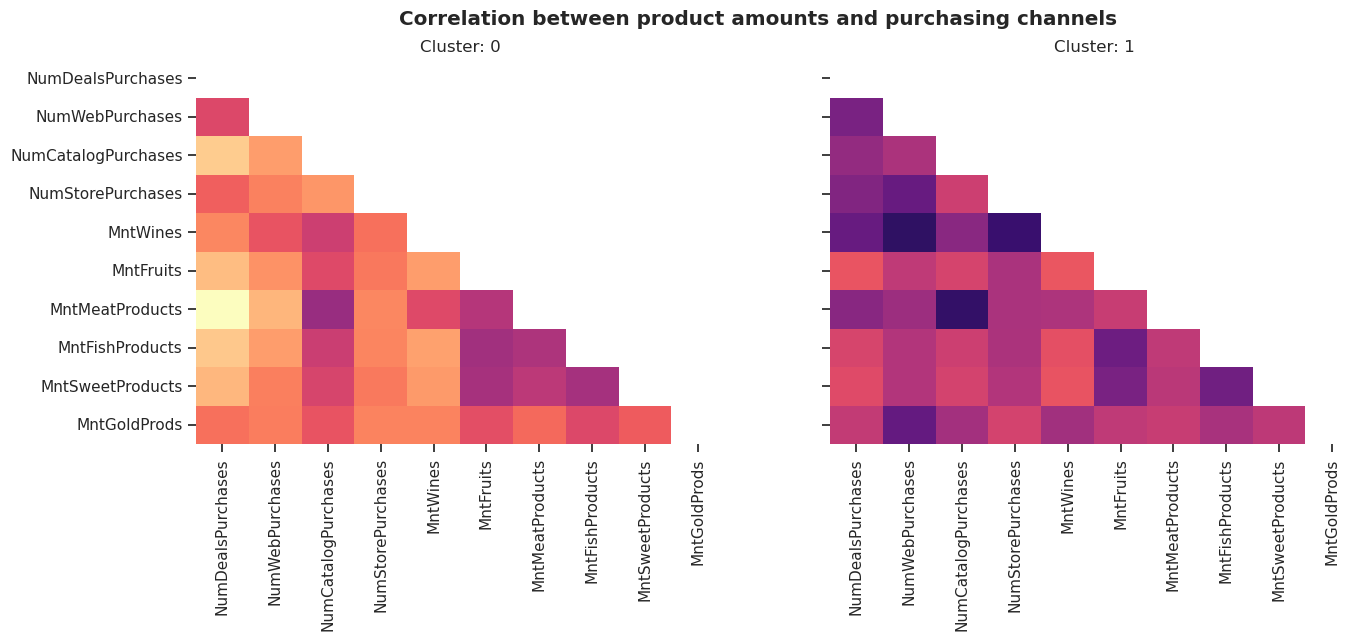

In [19]:
# Heat map between amount and purchases features
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15,5))
corr0 = round(df_raw[df_raw['ClusterLabels'] == 0][pur_col+mnt_col].corr(), 3)
corr1 = round(df_raw[df_raw['ClusterLabels'] == 1][pur_col+mnt_col].corr(), 3)

if corr0.values.min() > corr1.values.min():
    vmin = corr1.values.min()
else:
    vmin = corr0.values.min()
if corr0.values.max() > corr1.values.max():
    vmax = corr0.values.max()
else:
    vmax = corr1.values.max()

m = np.triu(np.ones_like(corr0))
sns.heatmap(
    corr0,
    ax=ax1,
    mask=m,
    cbar=False,
    vmin=vmin,
    vmax=vmax,
    cmap="magma_r"
)
sns.heatmap(
    corr1,
    ax=ax2,
    mask=m,
    cbar=False,
    vmin=vmin,
    vmax=vmax,
    cmap="magma_r"
)
ax1.set_title(label='Cluster: 0')
ax2.set_title(label='Cluster: 1')
fig.suptitle("Correlation between product amounts and purchasing channels", fontweight='bold')
plt.show()

**Insight**
* The products and places have a high correlation in cluster 1, which means they have more consistent shopping habits than cluster 0.<br>
* Cluster 0: There are some high correlations in cluster 0. Fruit, meat and fish products usually are bought together. The catalogue is a suitable channel to sell all products, especially meat products. <br>
* Cluster 1: They usually bought gold products via the website, meat products via catalogue and deal, and wines via various channels. Fruit, sweet and fish products usually buy together in stores and websites.

### 4 - Demographic and products

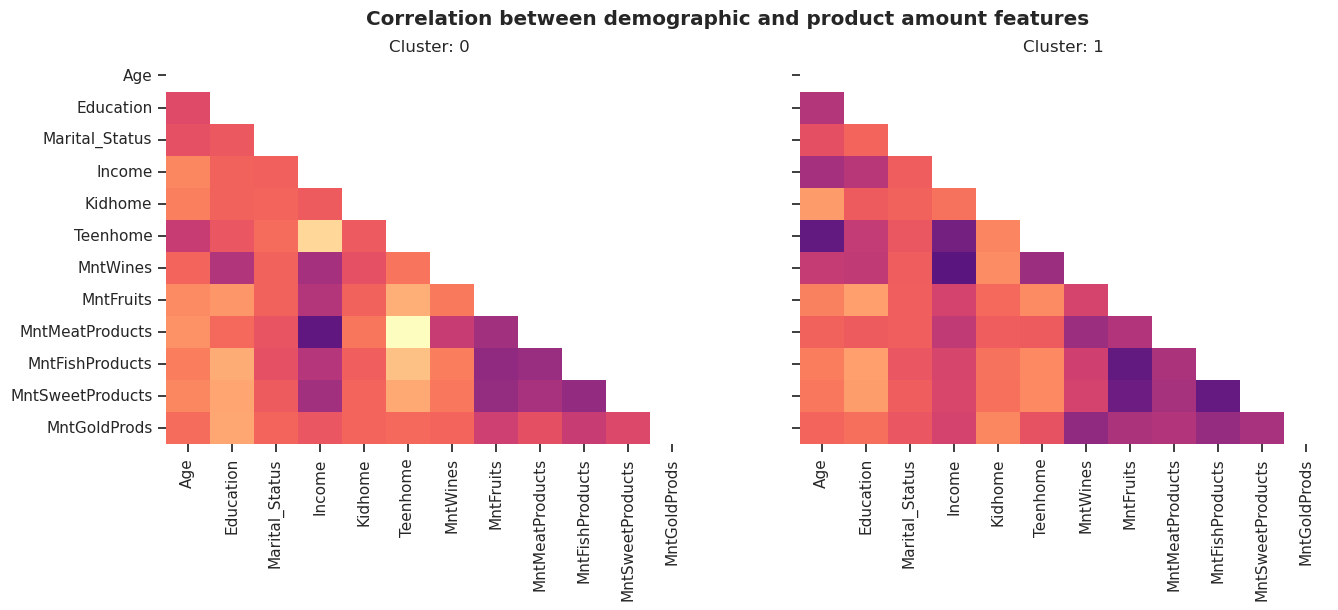

In [20]:
# Heat map demographic and amount features
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15,5))
corr0 = round(df[df['ClusterLabels'] == 0][demo_col+mnt_col].corr(), 3)
corr1 = round(df[df['ClusterLabels'] == 1][demo_col+mnt_col].corr(), 3)

if corr0.values.min() > corr1.values.min():
    vmin = corr1.values.min()
else:
    vmin = corr0.values.min()
if corr0.values.max() > corr1.values.max():
    vmax = corr0.values.max()
else:
    vmax = corr1.values.max()

m = np.triu(np.ones_like(corr0))
sns.heatmap(
    corr0,
    ax=ax1,
    mask=m,
    cbar=False,
    vmin=vmin,
    vmax=vmax,
    cmap="magma_r"
)
sns.heatmap(
    corr1,
    ax=ax2,
    mask=m,
    cbar=False,
    vmin=vmin,
    vmax=vmax,
    cmap="magma_r"
)
ax1.set_title(label='Cluster: 0')
ax2.set_title(label='Cluster: 1')
fig.suptitle(
    "Correlation between demographic and product amount features", fontweight='bold')
plt.show()

**Insight**: Income has high correlations with wines product in both clusters. <br> Let's get a detail visualisation for income.

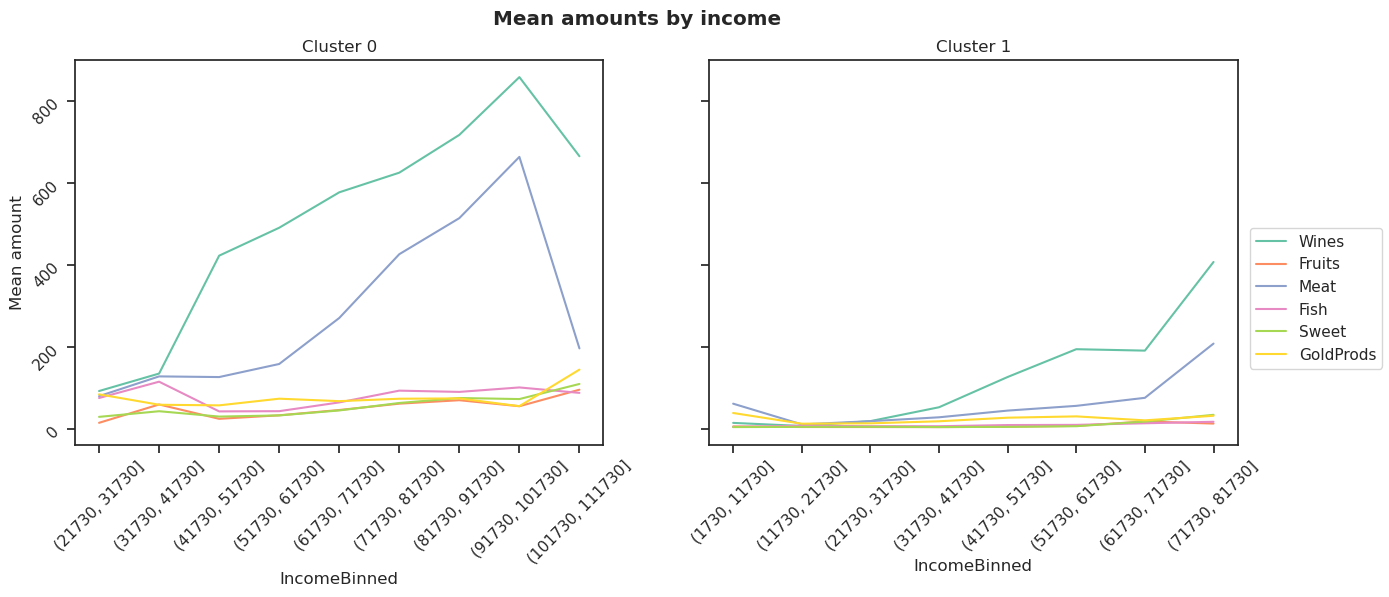

In [21]:
# Split income into bins.
df_raw['IncomeBinned'] = pd.cut(df_raw['Income'], np.arange(1730, 113734, 10000))

# Income and amount chart
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize= (15,5))
s0 = df_raw[df_raw['ClusterLabels'] == 0].groupby('IncomeBinned')[mnt_col].mean()
s0.plot.line(ax=ax1, legend=False)
s1 = df_raw[df_raw['ClusterLabels'] == 1].groupby('IncomeBinned')[mnt_col].mean()
s1.plot.line(ax=ax2, legend=False)

ax1.set_title('Cluster 0')
ax2.set_title('Cluster 1')
ax1.set_ylabel('Mean amount')
ax1.tick_params(labelrotation=45)
ax2.tick_params(labelrotation=45)

fig.legend(labels=[i[3:].replace('Products','') for i in mnt_col],
           loc='center right',
           ncol=1)
fig.suptitle('Mean amounts by income', fontweight='bold')
plt.show()

**Insight**: Income increases, wines and meat amount increase in both clusters.

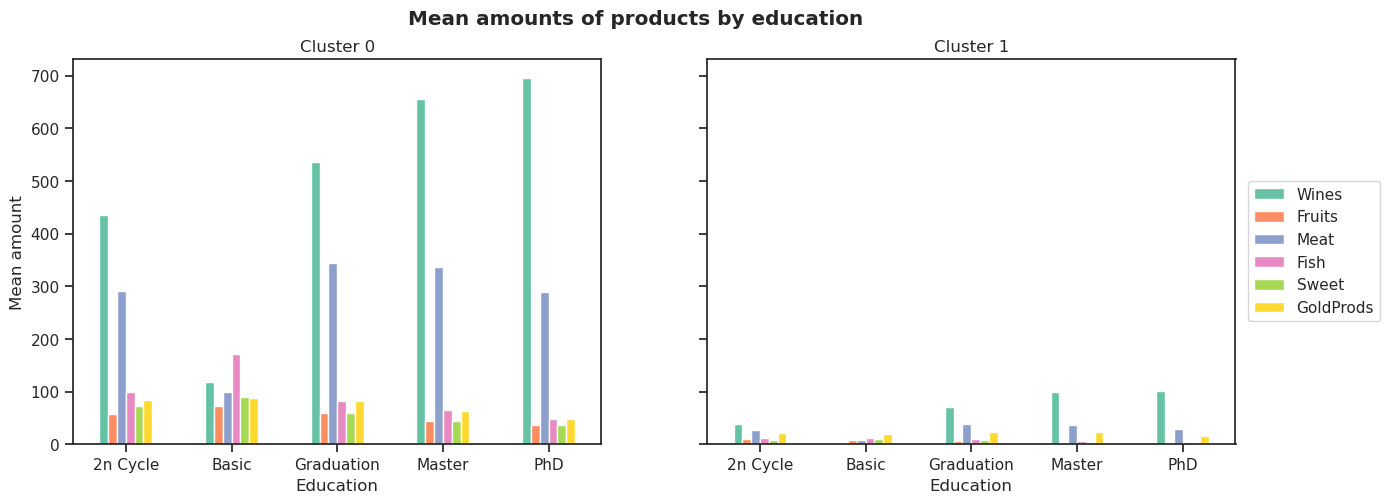

In [22]:
# Education and amount chart
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True,figsize= (15,5))
s0 = df_raw[df_raw['ClusterLabels'] == 0].groupby('Education')[mnt_col].mean()
s0.plot.bar(ax=ax1, legend=False)
s1 = df_raw[df_raw['ClusterLabels'] == 1].groupby('Education')[mnt_col].mean()
s1.plot.bar(ax=ax2, legend=False)

ax1.set_title('Cluster 0')
ax2.set_title('Cluster 1')
ax1.set_ylabel('Mean amount')
ax1.tick_params(labelrotation=0)
ax2.tick_params(labelrotation=0)

fig.legend(labels=[i[3:].replace('Products','') for i in mnt_col],
           loc='center right',
           ncol=1)
fig.suptitle('Mean amounts of products by education', fontweight='bold')
plt.show()

**Insight**: While wines and meat products have high mean amounts in most education groups in both clusters, education basic is the only group with different patterns of amounts. Members having basic qualifications spend more on fish products in cluster 0 and gold products in cluster 1.

### 5 - Demographic and channels
Overview the relations using heatmap chart.

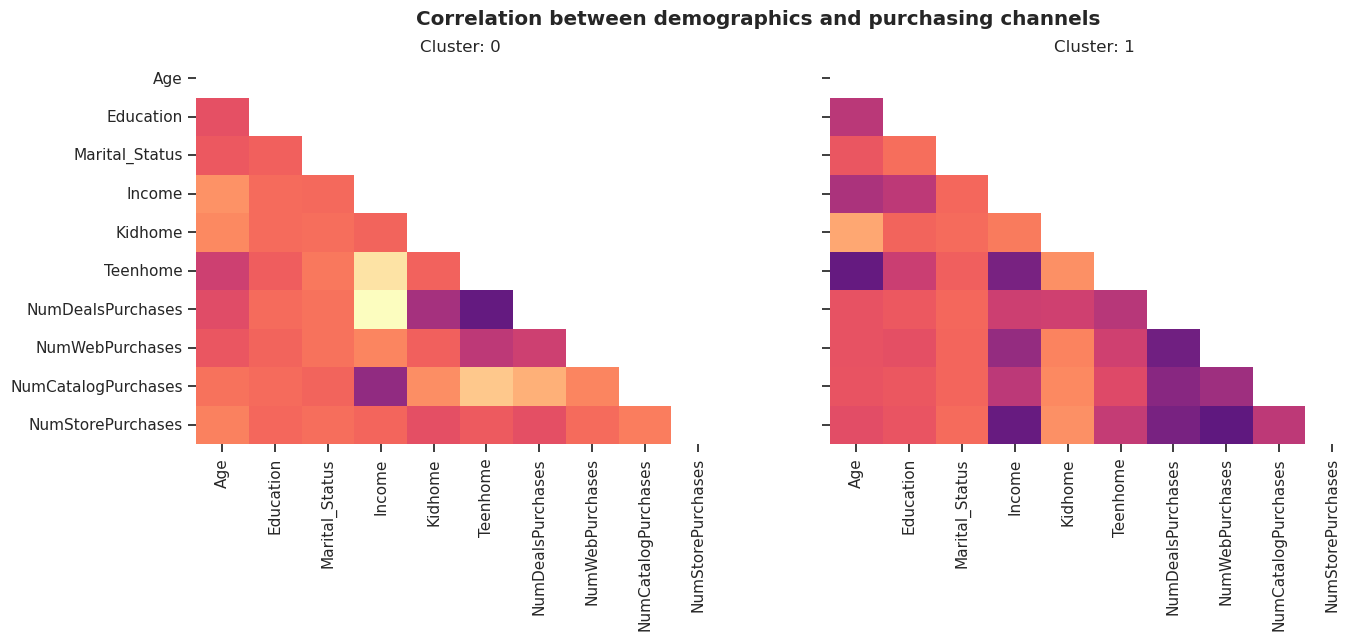

In [23]:
# Heat map demographic and purchasing channels chart
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15,5))
corr0 = round(df[df['ClusterLabels'] == 0][demo_col+pur_col].corr(), 3)
corr1 = round(df[df['ClusterLabels'] == 1][demo_col+pur_col].corr(), 3)

if corr0.values.min() > corr1.values.min():
    vmin = corr1.values.min()
else:
    vmin = corr0.values.min()
if corr0.values.max() > corr1.values.max():
    vmax = corr0.values.max()
else:
    vmax = corr1.values.max()

m = np.triu(np.ones_like(corr0))
sns.heatmap(
    corr0,
    ax=ax1,
    mask=m,
    cbar=False,
    vmin=vmin,
    vmax=vmax,
    cmap="magma_r"
)
sns.heatmap(
    corr1,
    ax=ax2,
    mask=m,
    cbar=False,
    vmin=vmin,
    vmax=vmax,
    cmap="magma_r"
)
ax1.set_title(label='Cluster: 0')
ax2.set_title(label='Cluster: 1')
fig.suptitle(
    "Correlation between demographics and purchasing channels", fontweight='bold')
plt.show()

**Insight**
* When income increases, they tend to buy more in all channels in cluster 1, while in cluster 0, people buy more through the catalogue and do not care much about deals.
* Households with more kids and teens tend to make deal purchases more in both clusters.

The charts below show more detail.

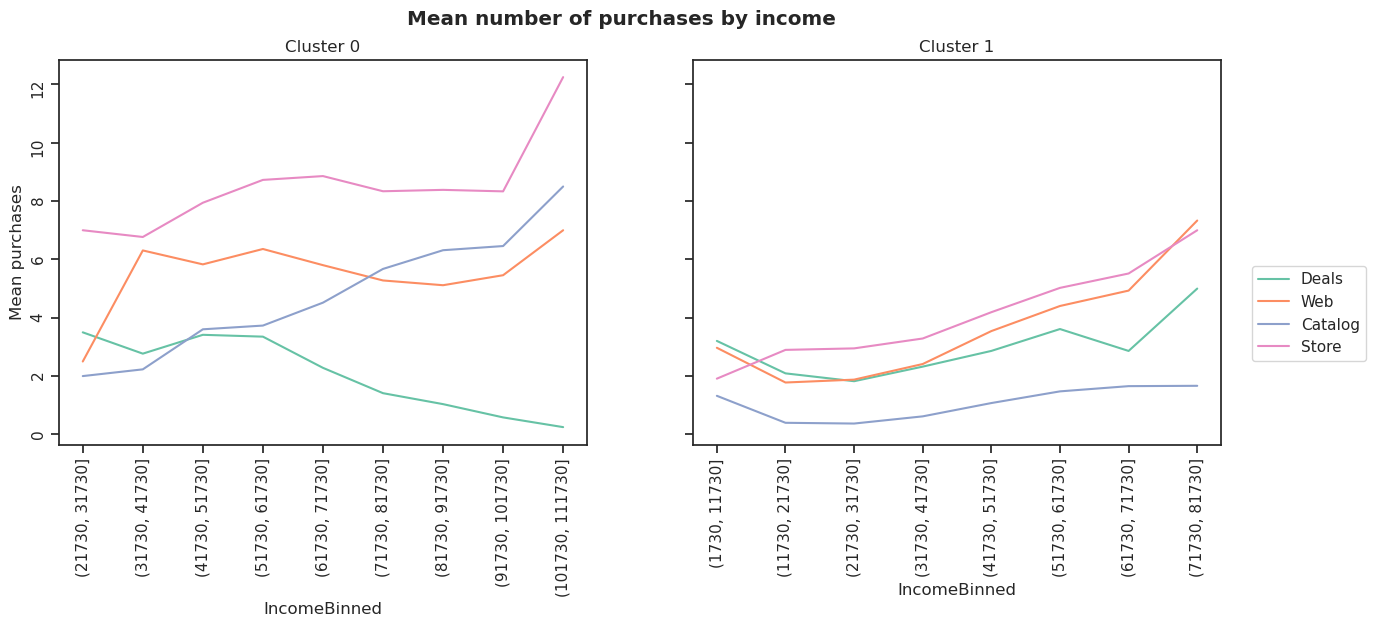

In [24]:
# Income and purchasing channel chart
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize= (15,5))
s0 = df_raw[df_raw['ClusterLabels'] == 0].groupby('IncomeBinned')[
    pur_col].mean()
s0.plot.line(ax=ax1, legend=False)
s1 = df_raw[df_raw['ClusterLabels'] == 1].groupby('IncomeBinned')[
    pur_col].mean()
s1.plot.line(ax=ax2, legend=False)

ax1.set_title('Cluster 0')
ax2.set_title('Cluster 1')
ax1.set_ylabel('Mean purchases')
ax1.tick_params(labelrotation=90)
ax2.tick_params(labelrotation=90)


fig.legend(labels=[i[3:-9] for i in pur_col],
           loc='center right',
           ncol=1,
           bbox_transform=fig.transFigure)
fig.suptitle('Mean number of purchases by income', fontweight='bold')
plt.show()

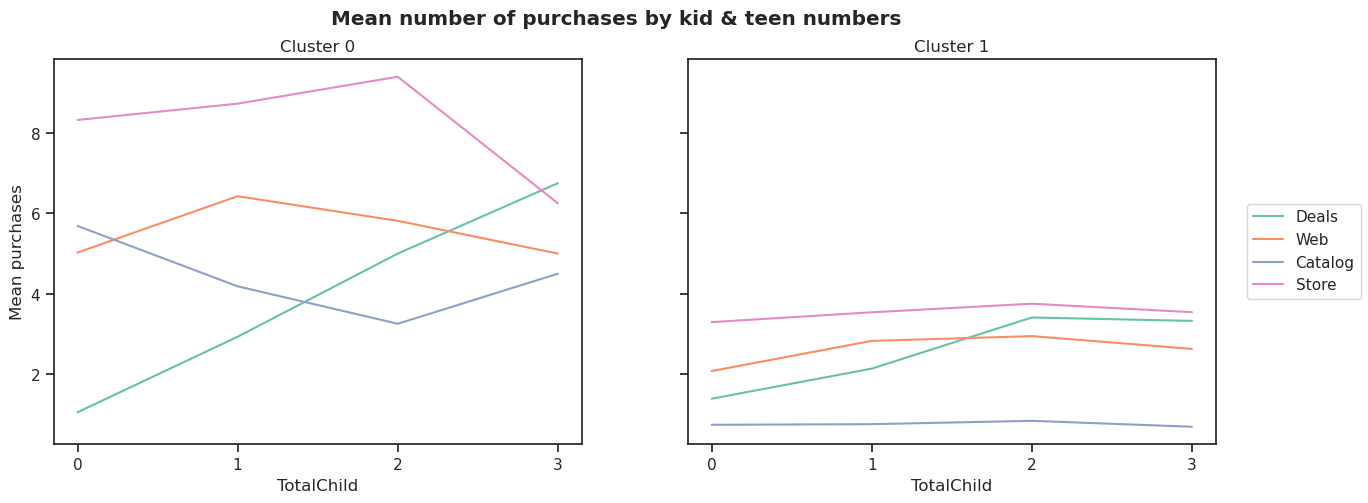

In [25]:
# Compute total child in the household
df_raw['TotalChild'] = df_raw['Kidhome']+df['Teenhome']

# Number of childrena and channels chart
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize= (15,5))
s0 = df_raw[df_raw['ClusterLabels'] == 0].groupby('TotalChild')[pur_col].mean()
s0.plot.line(ax=ax1, legend=False)
s1 = df_raw[df_raw['ClusterLabels'] == 1].groupby('TotalChild')[pur_col].mean()
s1.plot.line(ax=ax2, legend=False)

ax1.set_title('Cluster 0')
ax2.set_title('Cluster 1')
ax1.set_ylabel('Mean purchases')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))

fig.legend(labels=[i[3:-9] for i in pur_col],
           loc='center right',
           ncol=1,
           bbox_transform=fig.transFigure)
fig.suptitle('Mean number of purchases by kid & teen numbers', fontweight='bold')

plt.show()

# Build prediction models

In [26]:
# Define the test evaluation function
def eval_model(clf, m_type,x_train, y_train, x_test, y_test,y_pred,y_proba):
    '''
    Run cross validation for the given model and 
    compute evaluation metrics.
    '''
    def plot_roc_curve(true_y, y_prob, auc, type):
        # plot the roc curve based of the probabilities
        fpr, tpr, _ = roc_curve(true_y, y_prob[:, 1])
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.plot([0, 1], [0, 1], 'r--')
        #plt.grid()
        plt.title(label="Model %s (AUC: %s)" % (m_type, auc))

    # Compute evaluation metrics
    scores = cross_val_score(clf, x_train, y_train, cv=10)
    accuracy_mean = scores.mean()
    cfm = pd.crosstab(
        y_test,
        y_pred,
        rownames=['Actual'],
        colnames=['Predicted']
        )
    auc = round(roc_auc_score(list(y_test),list(y_pred)), 3)
    # Print out results
    print("K-Fold Validation Mean Accuracy: %s " % accuracy_mean)
    print(" ")
    print("Confusion matrix: \n %s " % cfm)
    print(" ")
    print("Evaluation metrics: \n %s " % classification_report(list(y_test),list(y_pred)))
    # Get ROC plot for model
    roc = plot_roc_curve(list(y_test), y_proba, auc, m_type)
    plt.show()

    return None

In [27]:
# Get X and y datasets
X= df_scaled.drop('ClusterLabels',axis=1)
y = df_y
print('Label counts: \n %s' % y.value_counts())
print (' ')

#Split dataset into 80% train and 20% test
train = pd.concat([X,y],axis=1).sample(frac=0.8,random_state=200)
test = pd.concat([X,y],axis=1).drop(train.index)

train_s = train.drop(['Response'],axis=1).shape
test_s = test.drop(['Response'],axis=1).shape

print('Training size: %s' % str(train_s))
print('Testing size: %s' % str(test_s))

Label counts: 
 0    1866
1     330
Name: Response, dtype: int64
 
Training size: (1757, 25)
Testing size: (439, 25)


The dataset is imbalanced with more label 0 data. Hence, using `SMOTE()` helps balance the training data and improves the forecast.

In [28]:
#Oversampling
smote = SMOTE()
x_train, y_train = smote.fit_resample(train.drop(['Response'],axis=1),train['Response'].astype('int'))

x_test= test.drop(['Response'],axis=1)
y_test = test['Response']

print('Train data - label counts before oversampling: \n %s' % train['Response'].value_counts())
print('Train data - label counts after oversampling: \n %s' % y_train.value_counts())
print (' ')

print('Training set size: \n %s' % str(x_train.shape))
print('Testing set size: \n %s' % str(x_test.shape))

Train data - label counts before oversampling: 
 0    1483
1     274
Name: Response, dtype: int64
Train data - label counts after oversampling: 
 1    1483
0    1483
Name: Response, dtype: int64
 
Training set size: 
 (2966, 25)
Testing set size: 
 (439, 25)


Testing with 3 classifiers: RandomForestClassifier, XGBClassifier and LogisticRegression.

K-Fold Validation Mean Accuracy: 0.9406884156884159 
 
Confusion matrix: 
 Predicted    0   1
Actual            
0          359  24
1           22  34 
 
Evaluation metrics: 
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       383
           1       0.59      0.61      0.60        56

    accuracy                           0.90       439
   macro avg       0.76      0.77      0.77       439
weighted avg       0.90      0.90      0.90       439
 


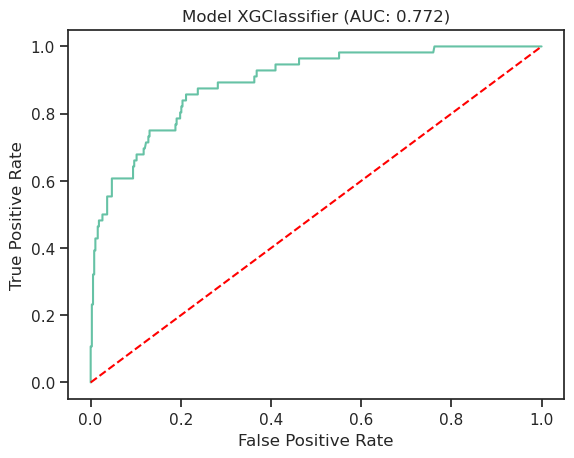

In [29]:
# XG model
xg_clf = xgb.XGBClassifier(random_state=0).fit(x_train,y_train)
eval_model(xg_clf,
           'XGClassifier',
           x_train,
           y_train,
           x_test,
           y_test,
           xg_clf.predict(x_test),
           xg_clf.predict_proba(x_test))

K-Fold Validation Mean Accuracy: 0.9528084903084905 
 
Confusion matrix: 
 Predicted    0   1
Actual            
0          362  21
1           27  29 
 
Evaluation metrics: 
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       383
           1       0.58      0.52      0.55        56

    accuracy                           0.89       439
   macro avg       0.76      0.73      0.74       439
weighted avg       0.89      0.89      0.89       439
 


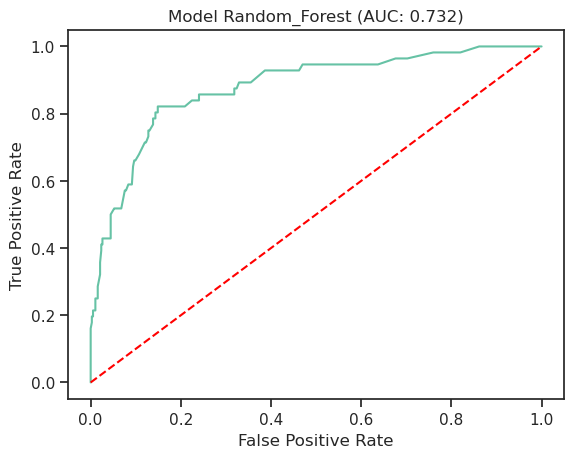

In [30]:
# Random Forest model
rf_clf = RandomForestClassifier(random_state=0).fit(x_train,y_train)
eval_model(rf_clf,
           'Random_Forest',
           x_train,
           y_train,
           x_test,
           y_test,
           rf_clf.predict(x_test),
           rf_clf.predict_proba(x_test))


K-Fold Validation Mean Accuracy: 0.8280473655473657 
 
Confusion matrix: 
 Predicted    0   1
Actual            
0          322  61
1           13  43 
 
Evaluation metrics: 
               precision    recall  f1-score   support

           0       0.96      0.84      0.90       383
           1       0.41      0.77      0.54        56

    accuracy                           0.83       439
   macro avg       0.69      0.80      0.72       439
weighted avg       0.89      0.83      0.85       439
 


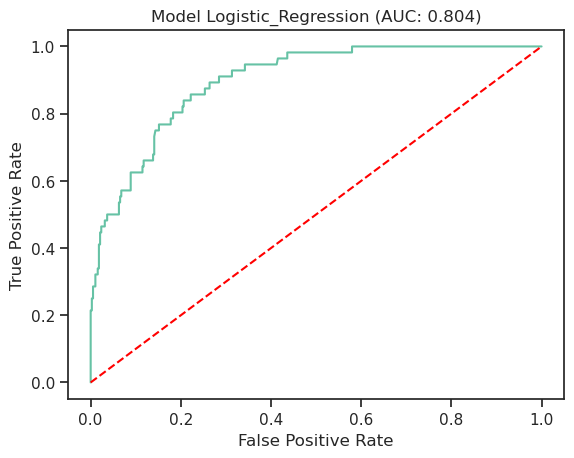

In [31]:
# Logistic Regression
lr_clf = LogisticRegression(random_state=0).fit(x_train,y_train)
eval_model(lr_clf,
           'Logistic_Regression',
           x_train,
           y_train,
           x_test,
           y_test,
           lr_clf.predict(x_test),
           lr_clf.predict_proba(x_test))

Overall, `XGBClassifier` has the best performance with high F1 score in both classes.